# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

*Импорт необходимых библиотек* 

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

## Загрузка и подготовка данных

<font color = 'blue'> Выполним подготовку данных по следующим действиям: </font>

1. Загрузить данные, выгрузить общую информацию о датасетах, проведем небольшой исследовательский анализ
2. Проверить на дубликаты, если имеются, то избавиться от них 
3. Масштабировать и закодировать данные с использованием пайплайна

In [7]:
geo_data_1 = pd.read_csv(r"C:\Users\nssavinov\Desktop\Пректы практикум\9. Машинное обучение в бизнесе\geo_data_0.csv")
geo_data_2 = pd.read_csv(r"C:\Users\nssavinov\Desktop\Пректы практикум\9. Машинное обучение в бизнесе\geo_data_1.csv")
geo_data_3 = pd.read_csv(r"C:\Users\nssavinov\Desktop\Пректы практикум\9. Машинное обучение в бизнесе\geo_data_2.csv")

In [8]:
datas = [geo_data_1, geo_data_2, geo_data_3]

In [9]:
display([i.info() for i in datas])
display([i.sample(1) for i in datas])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

[None, None, None]

[          id        f0        f1        f2    product
 86839  hdGKg  1.940923  0.430479  2.666361  111.33898,
           id         f0        f1        f2    product
 62804  06JGg  10.479366  5.364413  1.998345  53.906522,
           id        f0        f1        f2     product
 73278  baDij -0.981757  3.942166  3.160204  142.761692]

**1.** Пропусков в таблице не имеется, все типы данных соответсвуют переменным. При подготовке данных необходимо будет только использовать масштабирование. 

Далее, исследовательский анализ, избавимся от айдишников в датасете и проверим на дубликаты 

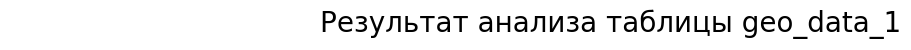

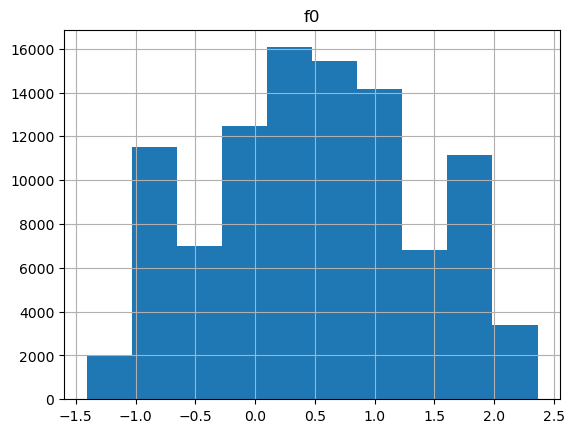

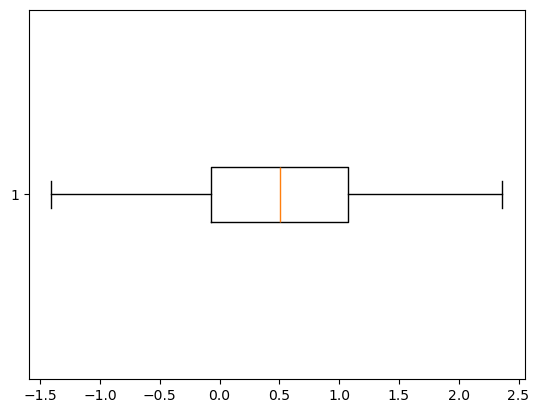

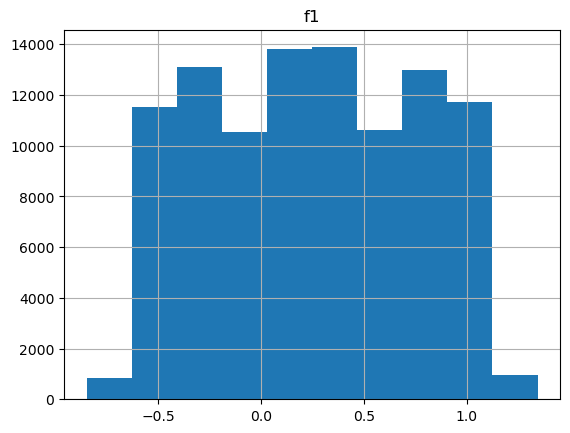

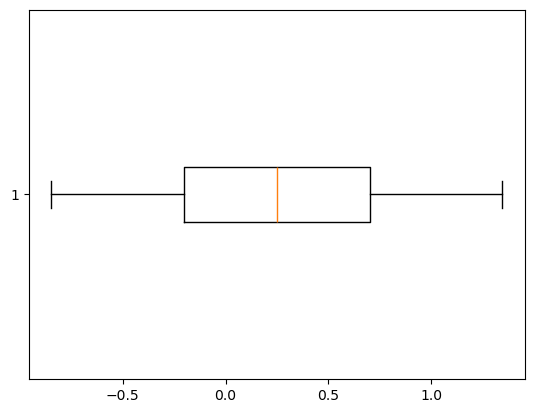

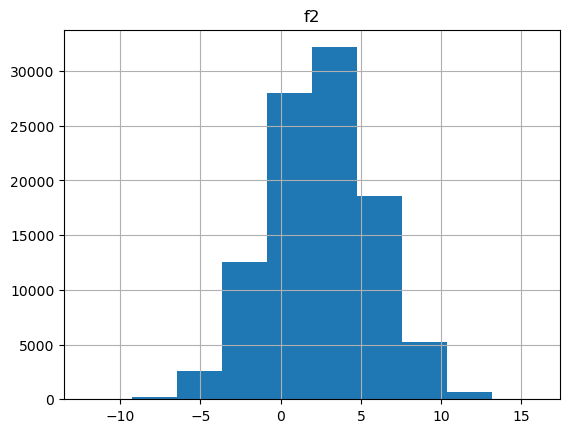

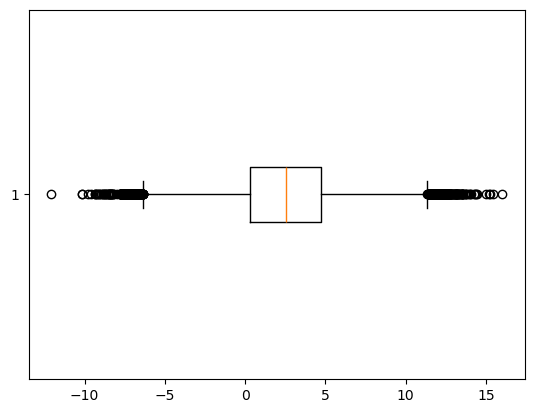

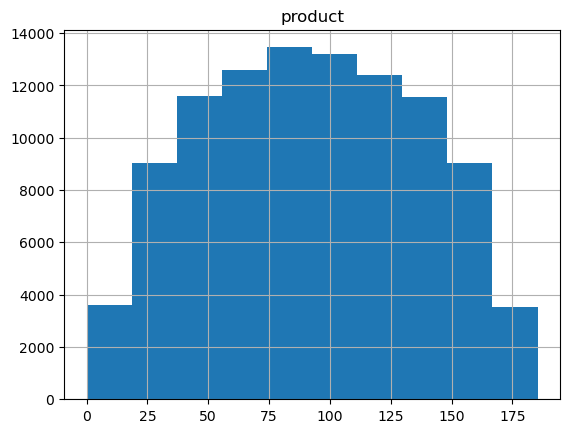

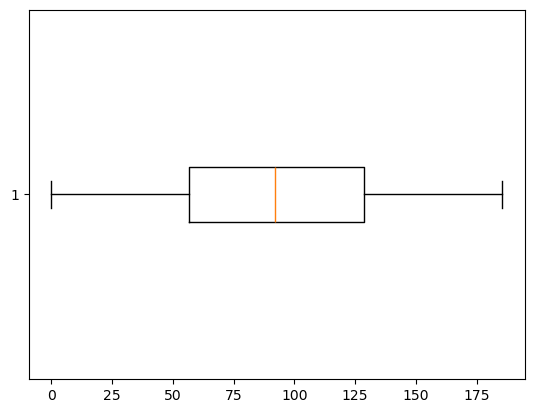

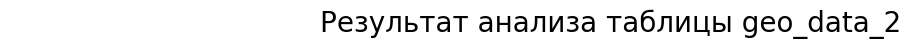

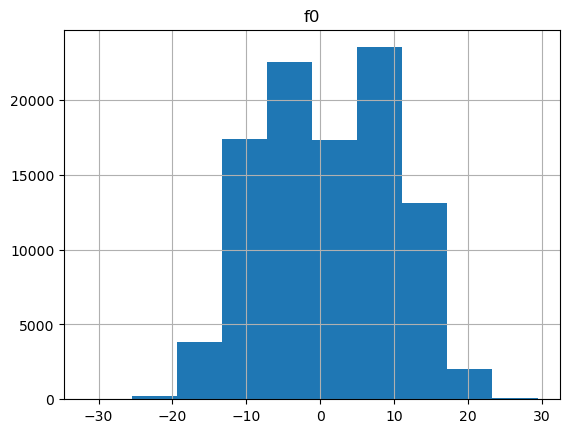

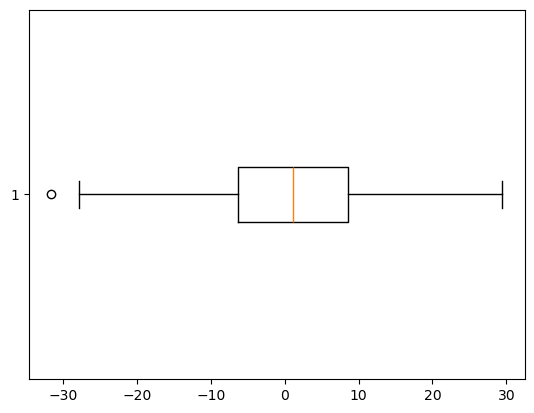

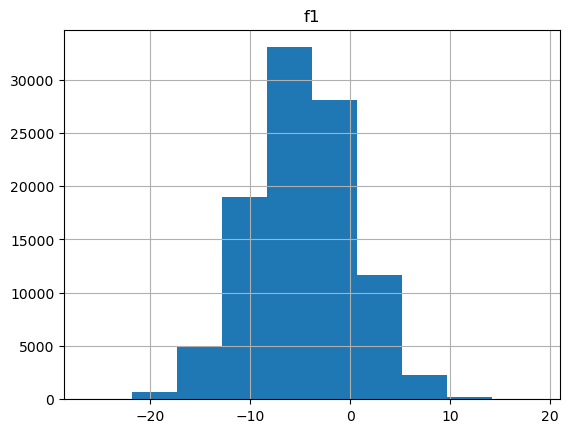

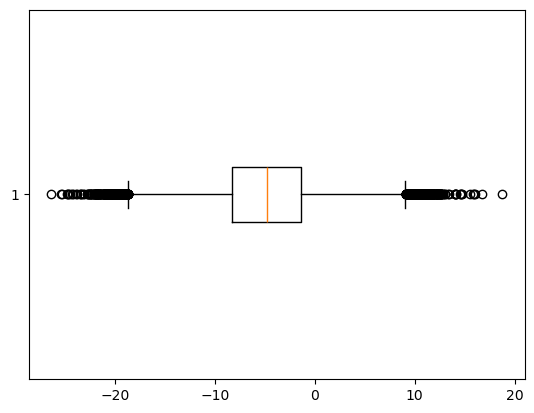

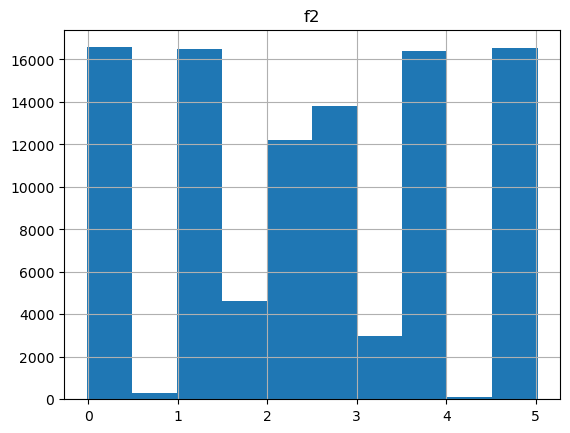

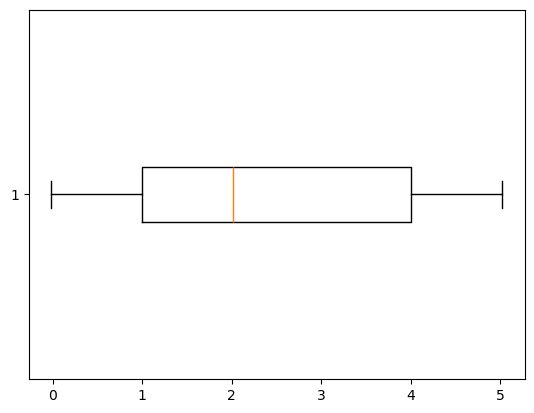

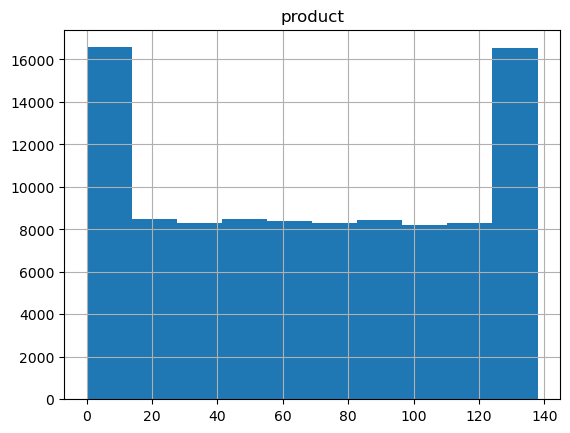

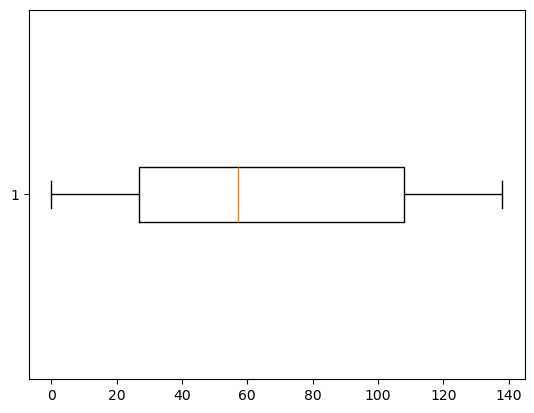

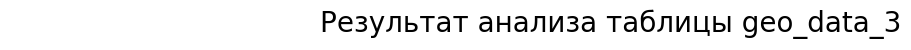

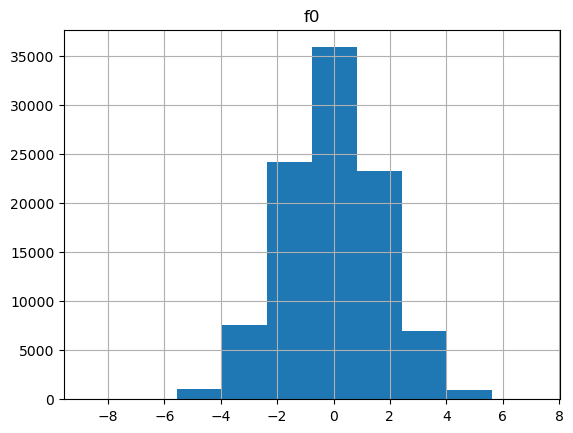

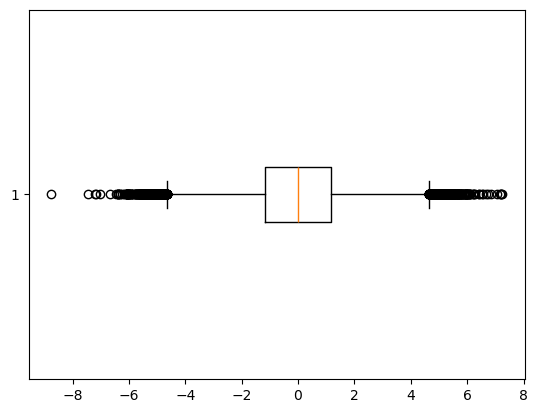

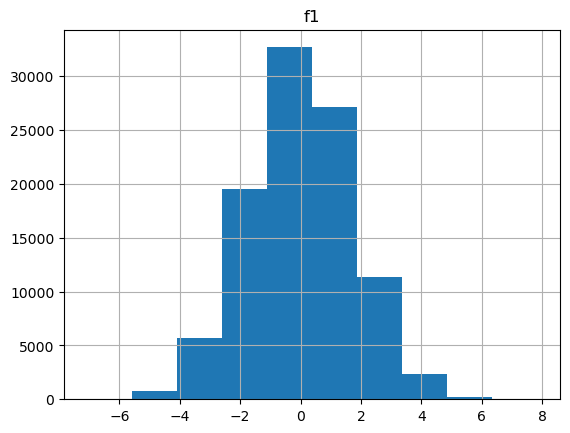

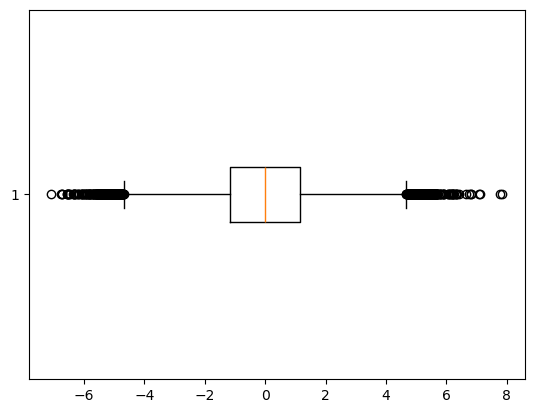

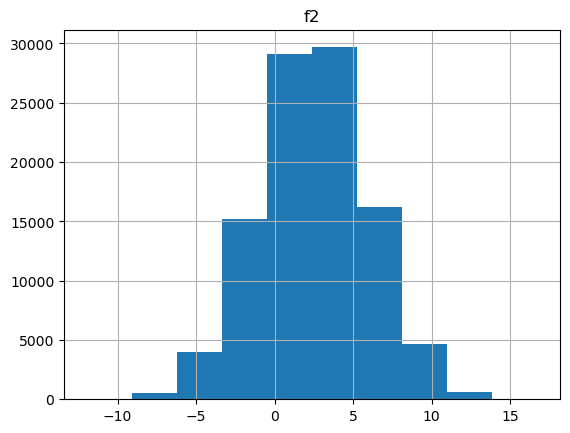

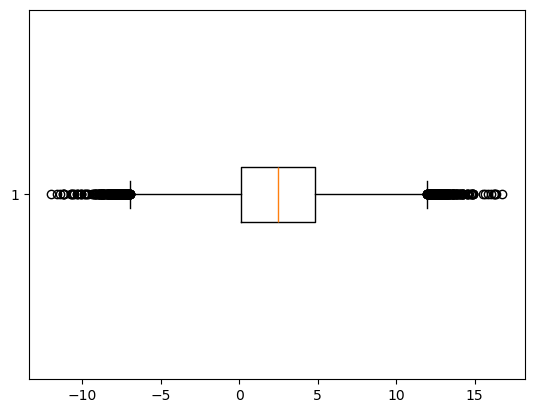

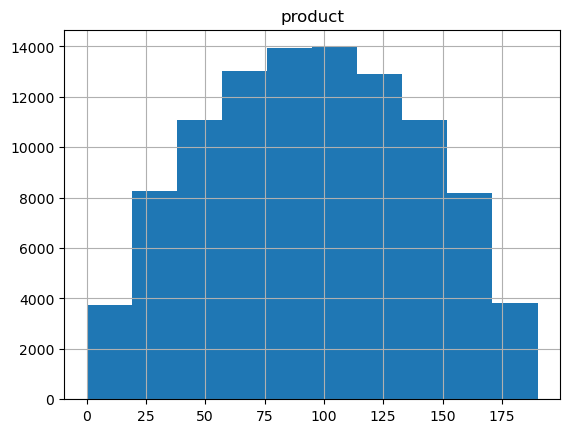

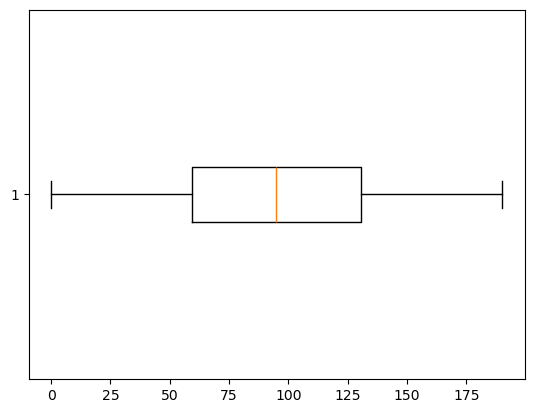

In [11]:
def analize(df, signs):
    plt.figure(figsize=(8, 0.2))
    plt.text(0.5, 0.5,f'Результат анализа таблицы {df.name}', fontsize=20)  
    plt.axis('off')
    plt.show()
    for sign in signs:
                
        df[sign].hist()
        plt.title(sign)
        plt.show()
        
        plt.boxplot(df[sign], vert = False)
        plt.show()
        

geo_data_1.name = 'geo_data_1'
analize (geo_data_1, ['f0', 'f1', 'f2', 'product'])
geo_data_2.name = 'geo_data_2'
analize (geo_data_2, ['f0', 'f1', 'f2', 'product'])
geo_data_3.name = 'geo_data_3'
analize (geo_data_3, ['f0', 'f1', 'f2', 'product'])

**Результат исследовательского анализа:**

необходимо произвести масштабирование данных перед обучением и исмользованием МО 

In [13]:
def clean_check(info):
    info = info.drop(columns = 'id', axis = 1)
    print(info.duplicated().sum())
    return info

In [14]:
geo_data_1 = clean_check(geo_data_1)
geo_data_2 = clean_check(geo_data_2)
geo_data_3 = clean_check(geo_data_3)

0
0
0


Дубликатов **не обнаруженно**. 

Далее сделаем трейновые и тестовые выборки, масштабируем их

In [16]:
X_1 = geo_data_1.drop(columns = 'product', axis = 1)
y_1 = geo_data_1['product']

X_2 = geo_data_2.drop(columns = 'product', axis = 1)
y_2 = geo_data_2['product']

X_3 = geo_data_3.drop(columns = 'product', axis = 1)
y_3 = geo_data_3['product']

In [17]:
test_size = 0.25
RANDOM_STATE = 44

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = test_size, random_state = RANDOM_STATE)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = test_size, random_state = RANDOM_STATE)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size = test_size, random_state = RANDOM_STATE)

In [18]:
num_columns = X_1_train.select_dtypes(include = 'number').columns

data_preprocessor = ColumnTransformer(transformers = 
                                      [
                                          ('num', StandardScaler(), num_columns)
                                      ],
                                     remainder = 'passthrough')

def transformer(X_train, X_test):
    x_transformed_train = data_preprocessor.fit_transform(X_train)
    x_transformed_test = data_preprocessor.transform(X_test)
    
    return(pd.DataFrame(x_transformed_train, columns = num_columns),
           pd.DataFrame(x_transformed_test, columns = num_columns))
    
X_1_train, X_1_test =  transformer(X_1_train, X_1_test)
X_2_train, X_2_test =  transformer(X_2_train, X_2_test)
X_3_train, X_3_test =  transformer(X_3_train, X_3_test)

<font color = 'blue' size = 5>Результатом выполнением текущего пункта является: </font>

1. Загружены данные, выгружена общая информацая о датасетах, проведем небольшой исследовательский анализ, убедились что данные необходимо масштабировать
2. После удалиения айдишников, поняли, что дубликатов в системе не имеется
3. Масштабировать данные с использованием пайплайна

<font color = 'green' size = 4><b>Можно приступать к следующему пункту, а именно, производить обучение модели и проверку ее качества

## Обучение и проверка модели

 По заданию требуется следующее: 
 
 1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25. - *сделано в предыдущем пункте*
 2. Обучите модель и сделайте предсказания на валидационной выборке.
 3. Сохраните предсказания и правильные ответы на валидационной выборке.
 4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
 5. Проанализируйте результаты.
 
Условие задачи в данном пункте: 
 
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [22]:
model = LinearRegression()

def model_calculation(x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    metrica = np.sqrt(mean_squared_error(y_test, y_pred))
    return(y_pred, metrica)

y_1_test_predict, RMSE_1= model_calculation(X_1_train, X_1_test, y_1_train, y_1_test)
y_2_test_predict, RMSE_2= model_calculation(X_2_train, X_2_test, y_2_train, y_2_test)
y_3_test_predict, RMSE_3= model_calculation(X_3_train, X_3_test, y_3_train, y_3_test)

In [23]:
def result_trasformstion(y_test, y_pred):
    y_test = pd.DataFrame(y_test).reset_index()
    y = pd.concat([y_test, pd.Series(y_pred)], axis = 1)
    y = y.rename(columns={0: 'predict'})
    return(y)

In [24]:
y_1 = result_trasformstion(y_1_test, y_1_test_predict)
y_2 = result_trasformstion(y_2_test, y_2_test_predict)
y_3 = result_trasformstion(y_3_test, y_3_test_predict)
y_3

,index,product,predict
0,39574,30.927826,96.177671
1,537,166.244516,87.006538
2,99246,93.182240,97.913842
3,39498,84.403121,56.762101
4,24797,104.505753,88.361431
...,...,...,...
24995,75642,124.321332,98.864000
24996,50108,122.328358,50.574154
24997,68698,135.448024,106.977212
24998,22229,151.468462,95.502595


In [25]:
print(f'Метрика первого датасета - {RMSE_1:.2f}')
print()
print(f'Метрика второго датасета - {RMSE_2:.2f}')
print()
print(f'Метрика третьего датасета - {RMSE_3:.2f}')

Метрика первого датасета - 37.77

Метрика второго датасета - 0.89

Метрика третьего датасета - 40.11


Вывод результатов после объединения таблиц.

In [27]:
def count_debit(y, n):
    plt.figure (figsize = (1,0.01))
    plt.text(0.5, 0.5, f'Изучение результатов предсказания по датасету № {n}', fontsize = 20)
    plt.axis('off') 
    plt.show()

    display(y.sample(5))
    
    plt.figure(figsize = (10,6))

    sns.histplot(data=y, x = 'product', color = 'green')
    sns.histplot(data=y, x = 'predict', color = 'red')

    plt.legend(title = 'Продуктивность', labels = ['Действительная', 'Предсказанная'])
    plt.xlabel ('Продуктивность скважины')
    plt.ylabel ('Количество')
    plt.show() 

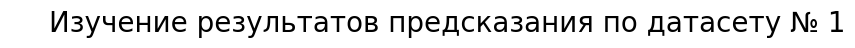

,index,product,predict
9393,89400,54.049823,54.904831
20327,47220,87.186826,90.870153
3367,56866,31.290099,76.849362
13097,69292,140.518095,122.437327
23515,27147,55.124234,53.851412


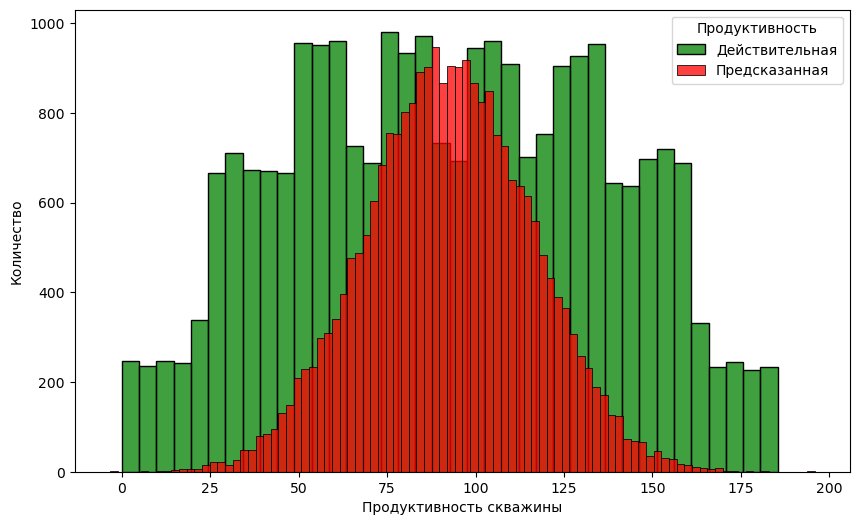

In [28]:
count_debit(y_1, 1)

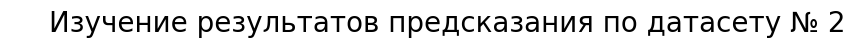

,index,product,predict
15459,70127,134.766305,135.221330
20084,65190,137.945408,137.861116
16675,28865,57.085625,56.607016
8529,45104,30.132364,30.331196
6308,33910,84.038886,84.303767


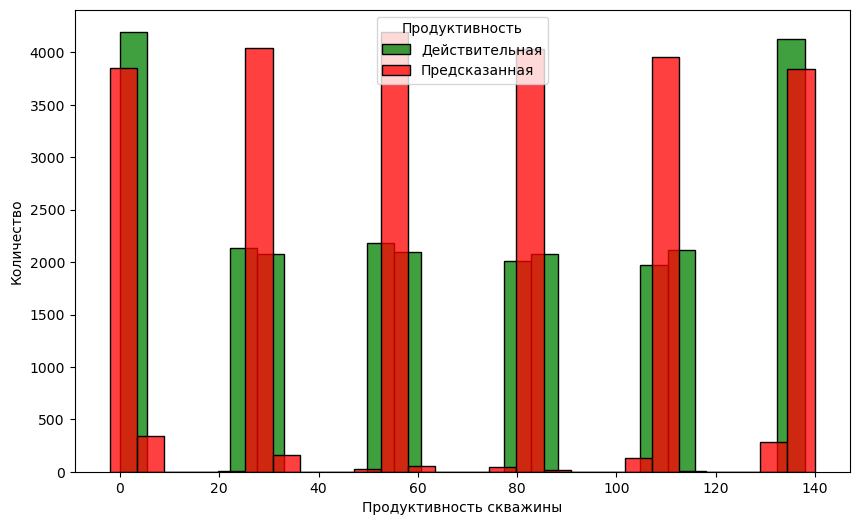

In [29]:
count_debit(y_2, 2)

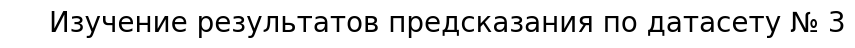

,index,product,predict
7281,22547,110.040130,106.098734
18316,71387,101.849218,104.968371
17176,38661,74.618919,90.733212
21121,55488,48.110042,74.115190
2894,76288,107.281261,108.355235


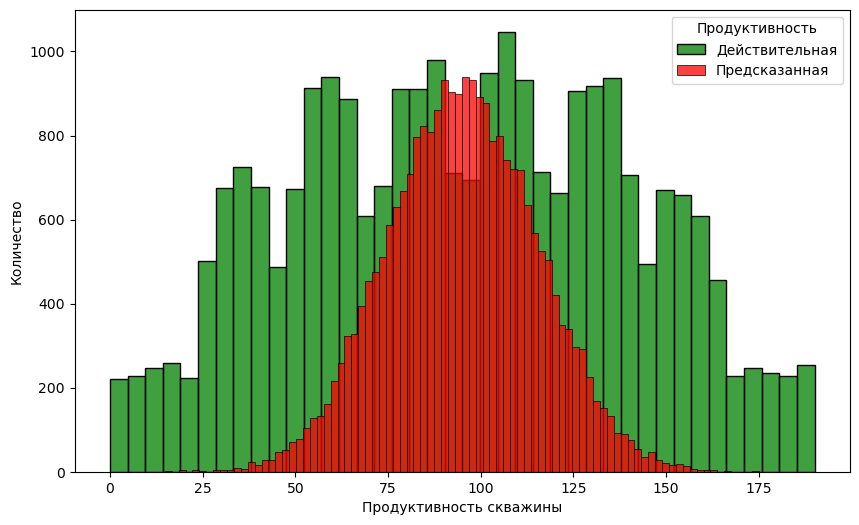

In [30]:
count_debit(y_3, 3)

<font color = 'blue' size = '5'><b> Результаты проведения данного пункта</b></font>

По результатам проведения данного пункта было выполнено следующее: 
1. 3 датасета было разбито на трейновые и тестовые выборки на основании которых проводилось обучение модели и ее проверка в последующем
2. Проведено обучение 3х моделей, расчитаны метрики на всех 3х моделях, по метрикам было показано, что лучше всего модель функционирует в 2м датасете
3. Результаты объединены в одном датафрейме и видно, что отличие действительно не сильное 
4. Построены гистограммы распределения из которых можно сделать вывод, 2 распределение +- одинаковое, по 1 и 3 видно что погрешность имеется. 

## Подготовка к расчёту прибыли

Подготовьтесь к расчёту прибыли:
 1. Все ключевые значения для расчётов сохраните в отдельных переменных.
 2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
 3. Напишите выводы по этапу подготовки расчёта прибыли.
 
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- Количество скважин которое будет выбираться = 200 штук! 

In [34]:
budget = 10_000_000_000
price_per_barrel = 450_000
well_numbers = 200

In [35]:
#Посчитаем среднюю продуктичность средней скваижны для того чтобы наши средства окупились 

average_well_production = round(budget / price_per_barrel / well_numbers, 2)

print(f'Среднюю продуктичность средней скважины для того чтобы наши средства окупились должна равняться = {average_well_production}')

Среднюю продуктичность средней скважины для того чтобы наши средства окупились должна равняться = 111.11


In [36]:
y_1.name = 'Регион 1'
y_2.name = 'Регион 2'
y_3.name = 'Регион 3'

for y in [y_1, y_2, y_3]:
    print(f'Ситуация в {y.name}')
    if y['product'].mean() < average_well_production:
        print('Средняя минимальная добыча для достижения безубыточности предприятия БОЛЬШЕ, чем средняя добыча на данном участке')
        print(f"{average_well_production} > {(y['product'].mean()).round(2)}")
    else: 
        print('Средняя минимальная добыча для достижения безубыточности предприятия МЕНЬШЕ, чем средняя добыча на данном участке')
        print(f"{average_well_production} < {(y['product'].mean()).round(2)}")
    print()

Ситуация в Регион 1
Средняя минимальная добыча для достижения безубыточности предприятия БОЛЬШЕ, чем средняя добыча на данном участке
111.11 > 92.47

Ситуация в Регион 2
Средняя минимальная добыча для достижения безубыточности предприятия БОЛЬШЕ, чем средняя добыча на данном участке
111.11 > 68.52

Ситуация в Регион 3
Средняя минимальная добыча для достижения безубыточности предприятия БОЛЬШЕ, чем средняя добыча на данном участке
111.11 > 94.87



<font color = 'blue' size = 5><b> Результаты выполнения данного пункта:</b></font>

1. Была расчитана средняя продуктивность скважины для достижения безубыточности предприятия = 111.11 т.б.
2. Так же проведено сравнение для всех 3х регионов со средней продуктивностью и было выявленно, что ни один из регионов не подходит для достижения безубыточности (если конечно, оценивать только по средним запасам на скважину), наиболее близкие результаты по добыче получились на 3й выборке. 2й регион дает наибольшую разницу между средними! 

## Напишите функцию для расчёта прибыли 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
1. Выберите скважины с максимальными значениями предсказаний. 
2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитайте прибыль для полученного объёма сырья.

In [40]:
def top_well_profit_count(y):
    top_well_predict = y.sort_values(by = 'predict', ascending = False).head(200)
    top_profit_summa = top_well_predict['product'].sum() * price_per_barrel - budget
    return (top_profit_summa)

In [41]:
profit_1 = top_well_profit_count(y_1)
profit_2 = top_well_profit_count(y_2)
profit_3 = top_well_profit_count(y_3)

In [42]:
[print(f'Прибыль для {y.name} = {round(profit/10e8, 2)} млрд.', end= '\n \n') for profit, y in [[profit_1, y_1], 
                                                                                                [profit_2, y_2], 
                                                                                                [profit_3, y_3]]]

Прибыль для Регион 1 = 3.26 млрд.
 
Прибыль для Регион 2 = 2.42 млрд.
 
Прибыль для Регион 3 = 2.32 млрд.
 


[None, None, None]

<font color = 'blue' size = 5><b> Результаты выполнения данного пункта:</b></font>

1. наиболее прибыльными по выбору лучших скважин является 1я выборка

## Расчёт прибыли и рисков 

Посчитайте риски и прибыль для каждого региона:
1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

**Расчет прибыли**

In [47]:
RANDOM_STATE = np.random.RandomState(12345)

values_1 = []
values_2 = []
values_3 = []

for y, values in [[y_1, values_1], [y_2, values_2], [y_3, values_3]]:
    for i in range(1000):
        subsample = y.sample(500, replace = True, random_state = RANDOM_STATE)
        summa = top_well_profit_count(subsample)
        values.append(summa)

In [48]:
print('Расчет 95%-й доверительного интервала')
print()
for value, y in [[values_1, y_1], [values_2, y_2], [values_3, y_3]]:
    value = pd.Series(value)
    print('-----------------------------------')
    print(f'Нижняя граница доверительного интервала {y.name} = {round(value.quantile(0.025), 1)}')
    print(f'Нижняя граница доверительного интервала {y.name} = {round(value.quantile(0.975), 1)}')
    print(f'Средняя прибыль - {round(value.mean(), 2)}')
    print('-----------------------------------')
    print()

Расчет 95%-й доверительного интервала

-----------------------------------
Нижняя граница доверительного интервала Регион 1 = -170114537.2
Нижняя граница доверительного интервала Регион 1 = 914091664.5
Средняя прибыль - 370585971.18
-----------------------------------

-----------------------------------
Нижняя граница доверительного интервала Регион 2 = 18133711.5
Нижняя граница доверительного интервала Регион 2 = 820230104.9
Средняя прибыль - 439489811.6
-----------------------------------

-----------------------------------
Нижняя граница доверительного интервала Регион 3 = -228030899.0
Нижняя граница доверительного интервала Регион 3 = 818227042.7
Средняя прибыль - 302584589.54
-----------------------------------



**Расчет рисков**

In [50]:
for value, y in [[values_1, y_1], [values_2, y_2], [values_3, y_3]]:
    value = pd.Series(value)
    negative_result = (value[value < 0].count()) / len(value)
    print('-----------------------------------')
    print(f'Риск получить отрицательную прибыль {y.name} = {negative_result* 100:.2f}%')
    print('-----------------------------------')

-----------------------------------
Риск получить отрицательную прибыль Регион 1 = 8.30%
-----------------------------------
-----------------------------------
Риск получить отрицательную прибыль Регион 2 = 1.90%
-----------------------------------
-----------------------------------
Риск получить отрицательную прибыль Регион 3 = 12.90%
-----------------------------------


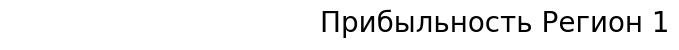

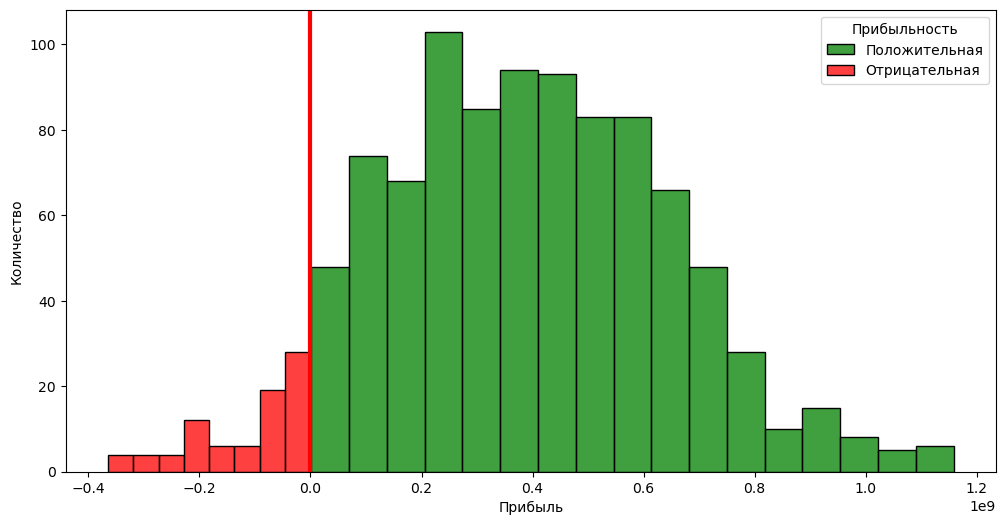

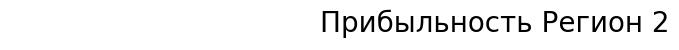

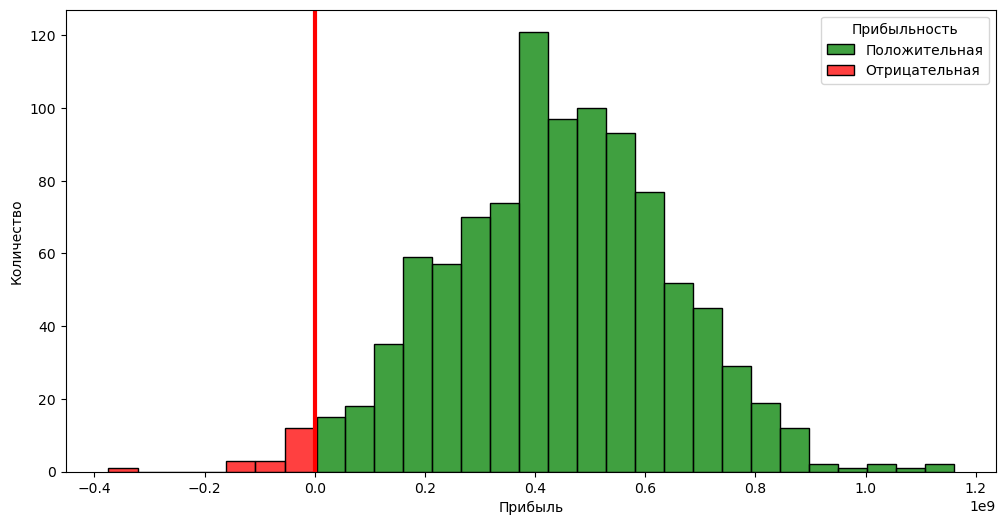

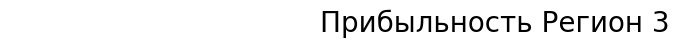

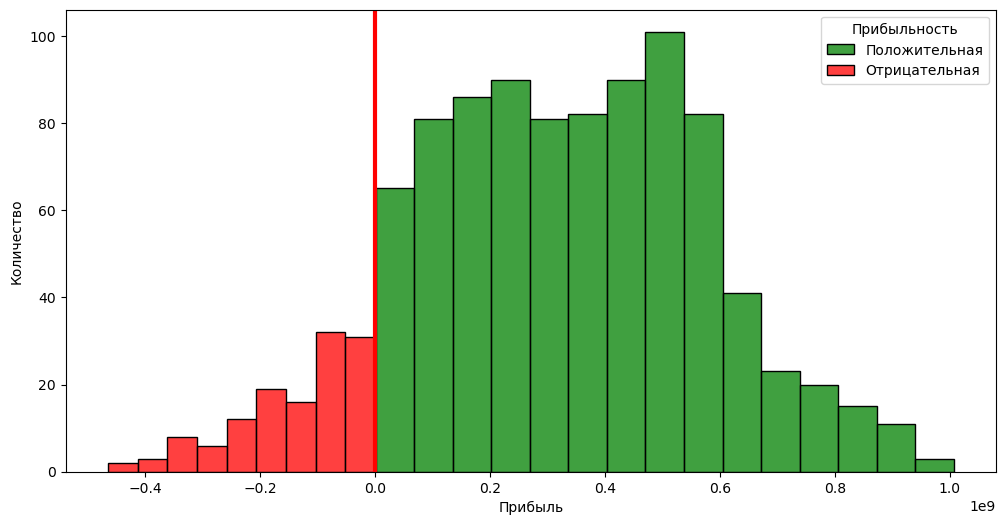

In [51]:
for value, y in [[values_1, y_1], [values_2, y_2], [values_3, y_3]]:
    plt.figure(figsize=(8, 0.2))
    plt.text(0.5, 0.5,f'Прибыльность {y.name}', fontsize=20)  
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    value = pd.Series(value)
    sns.histplot(value[value > 0], color = 'green')
    sns.histplot(value[value < 0], color = 'red')
    plt.legend(title = 'Прибыльность', labels = ['Положительная', 'Отрицательная'])
    plt.xlabel('Прибыль')
    plt.ylabel('Количество')
    plt.axvline(x = 0, color = 'red', lw=3)
    plt.show()

<font color = 'blue' size = 5><b> Результаты выполнения данного пункта:</b></font>

1. Была применена техника bootstrap где 1000 раз с всего датасета были выбраны рандомно по 500 скважин
2. На каждом пуле скважин был оценен профит от по созданной формуле о выручке на 200 лучших предсказанных скважинах 
3. Получены на 3х датасетах 95% доверительный интервал
4. Получен выручка в 2.5% квантиле, а также возможные убытки
5. Посчитаны риски, меньше всего рисков на 2м датасете. 1.9%

<font color = 'green' size = 5><b> Заключение проекта:</b></font>

В результате выполнения данного проекта: 
1. Загружены данные, выгружена общая информацая о датасетах, проведем небольшой исследовательский анализ, убедились что данные необходимо масштабировать. После удалиения айдишников, поняли, что дубликатов в системе не имеется. Масштабировать данные с использованием пайплайна
2. 3 датасета было разбито на трейновые и тестовые выборки на основании которых проводилось обучение модели и ее проверка в последующем. Проведено обучение 3х моделей, расчитаны метрики на всех 3х моделях, по метрикам было показано, что лучше всего модель функционирует в 2м датасете. Результаты объединены в одном датафрейме и видно, что отличие действительно не сильное. Построены гистограммы распределения из которых можно сделать вывод, 2 распределение +- одинаковое, по 1 и 3 видно что погрешность имеется. 
3. Была расчитана средняя продуктивность скважины для достижения безубыточности предприятия = 111.11 тыс.б.. Так же проведено сравнение для всех 3х регионов со средней продуктивностью и было выявленно, что ни один из регионов не подходит для достижения безубыточности (если конечно, оценивать только по средним запасам на скважину), наиболее близкие результаты по добыче получились на 3й выборке. 2й регион дает наибольшую разницу между средними!
4. При сравнении всего датасета наиболее прибыльными по выбору лучших скважин является 1я выборка
5. Была применена техника bootstrap где 1000 раз с всего датасета были выбраны рандомно по 500 скважин. На каждом пуле скважин был оценен профит от по созданной формуле о выручке на 200 лучших предсказанных скважинах. Получены на 3х датасетах 95% доверительный интервал. Получен выручка в 2.5% квантиле, а также возможные убытки. Посчитаны риски, меньше всего рисков на 2м датасете. 1.9%

<font color = 'green' size = 4> Рекомендации:</font>

Принимаем к разрабоке 2й участок, т.к. риски минимальны - меньше 2х процентов получить отрицательную прибыль в результате работы, средняя выручка бустрапированая максимальная, модель лучше всего справляется на этих данных